In [1]:
import os
import hardposit as hp
import fixed2float as fi
from pathlib import Path
import re

In [20]:
import fixed2float
fixed2float.__version__

'4.0.0-rc1'

In [21]:
N, ES = 16, 1
M, B = 31, 64

In [22]:
with open(Path("../tb_core_op_fma.log"), 'r') as f:
  log = f.read()
print(log)

0x3524
(0x3524, 0x5e81) 0x000000032dff2400, 0x00005970
(0x5e81, 0xd609) 0x00000001a1fb6880, 0x00004a20
(0xd609, 0x5663) 0x000000007f592600, 0x00002fd6
(0x5663, 0x7b0d) 0x00000222df912600, 0x00007d11
(0x7b0d, 0x998d) 0xfffffca044b12600, 0x00008250
(0x998d, 0x8465) 0x0000032358d12600, 0x00007d92
(0x8465, 0x5212) 0x0000011a21a12600, 0x00007c1a
(0x5212, 0xe301) 0x00000119ac352f00, 0x00007c1a
(0xe301, 0xcd0d) 0x00000119cafdb0a0, 0x00007c1a
(0xcd0d, 0xf176) 0x00000119d2bc4080, 0x00007c1a
(0xf176, 0xcd3d) 0x00000119da673260, 0x00007c1a
(0xcd3d, 0x57ed) 0x000001181983ab60, 0x00007c18
(0x57ed, 0xf78c) 0x000001180c323ee0, 0x00007c18
(0xf78c, 0xe9f9) 0x000001180caf2d38, 0x00007c18
(0xe9f9, 0x24c6) 0x00000118039401e8, 0x00007c18
(0x24c6, 0x84c5) 0x000000d4e7f201e8, 0x00007b54
(0x84c5, 0xd2aa) 0x00000133acc401e8, 0x00007c34
(0xd2aa, 0xf7e5) 0x00000133aea5c230, 0x00007c34
(0xf7e5, 0x7277) 0x00000133447b8e30, 0x00007c33
(0x7277, 0xd612) 0x00000128ca616e30, 0x00007c29
(0xd612, 0xdb8f) 0x00000128eb820f

In [23]:
logs = log.splitlines()
print(logs)

['0x3524', '(0x3524, 0x5e81) 0x000000032dff2400, 0x00005970', '(0x5e81, 0xd609) 0x00000001a1fb6880, 0x00004a20', '(0xd609, 0x5663) 0x000000007f592600, 0x00002fd6', '(0x5663, 0x7b0d) 0x00000222df912600, 0x00007d11', '(0x7b0d, 0x998d) 0xfffffca044b12600, 0x00008250', '(0x998d, 0x8465) 0x0000032358d12600, 0x00007d92', '(0x8465, 0x5212) 0x0000011a21a12600, 0x00007c1a', '(0x5212, 0xe301) 0x00000119ac352f00, 0x00007c1a', '(0xe301, 0xcd0d) 0x00000119cafdb0a0, 0x00007c1a', '(0xcd0d, 0xf176) 0x00000119d2bc4080, 0x00007c1a', '(0xf176, 0xcd3d) 0x00000119da673260, 0x00007c1a', '(0xcd3d, 0x57ed) 0x000001181983ab60, 0x00007c18', '(0x57ed, 0xf78c) 0x000001180c323ee0, 0x00007c18', '(0xf78c, 0xe9f9) 0x000001180caf2d38, 0x00007c18', '(0xe9f9, 0x24c6) 0x00000118039401e8, 0x00007c18', '(0x24c6, 0x84c5) 0x000000d4e7f201e8, 0x00007b54', '(0x84c5, 0xd2aa) 0x00000133acc401e8, 0x00007c34', '(0xd2aa, 0xf7e5) 0x00000133aea5c230, 0x00007c34', '(0xf7e5, 0x7277) 0x00000133447b8e30, 0x00007c33', '(0x7277, 0xd612) 0x

In [24]:
pattern = r"0x[0-9a-z]+"

diff_fma = [0] * len(logs)
diff_normal_mul = [0] * len(logs)

acc = 0
for (i, item) in enumerate(logs):
  results = re.findall(pattern, item)
  if len(results) == 1:
    p3 = hp.from_bits(int(results[0], 16), N, ES)
    po_std_mul = p3
    acc += p3.eval()
  else:
    p1 = hp.from_bits(int(results[0], 16), N, ES)
    p2 = hp.from_bits(int(results[1], 16), N, ES)
    print(p1.eval(), p2.eval(), (p1*p2).eval())

    fixed = fi.from_bits(int(results[2], 16), M, B)
    print(f"fixed={fixed}")
    
    po_fma = hp.from_bits(int(results[3], 16), N, ES)
    po_std_mul += p1 * p2 
    print(f"po_fma     = {po_fma}")
    print(f"po_std_mul = {po_std_mul}")
    
    acc += p1.eval() * p2.eval()
    print(f"acc={acc}")
    
    diff_normal_mul[i] = abs(po_std_mul.eval() - acc)
    diff_fma[i] = abs(po_fma.eval() - acc)
    
    print()
    assert acc == fixed.eval(), f"acc = {acc}, fixed = {fixed.eval()}"

0.66064453125 3.81298828125 2.51904296875
fixed=0000000000000000000000000000001100101101111111110010010000000000 Fx<31,64>(13656597504) 3.1796743869781494
po_fma     = 0101100101110000 P<16,1>(22896) 3.1796875
po_std_mul = 0101100101110000 P<16,1>(22896) 3.1796875
acc=3.1796743869781494

3.81298828125 -0.40570068359375 -1.546875
fixed=0000000000000000000000000000000110100001111110110110100010000000 Fx<31,64>(7012575360) 1.6327424347400665
po_fma     = 0100101000100000 P<16,1>(18976) 1.6328125
po_std_mul = 0100101000100000 P<16,1>(18976) 1.6328125
acc=1.6327424347400665

-0.40570068359375 2.79833984375 -1.13525390625
fixed=0000000000000000000000000000000001111111010110010010011000000000 Fx<31,64>(2136548864) 0.49745404720306396
po_fma     = 0010111111010110 P<16,1>(12246) 0.4974365234375
po_std_mul = 0010111111011000 P<16,1>(12248) 0.49755859375
acc=0.49745404720306396

2.79833984375 195.25 546.0
fixed=0000000000000000000000100010001011011111100100010010011000000000 Fx<31,64>(2348802975

In [32]:
hp.from_double(acc, N, ES)

1111111001011100 P<16,1>(33188) -1760.0

## Plotting displacement from 0, FMA vs std posit mul

In [33]:
import matplotlib.pyplot as plt

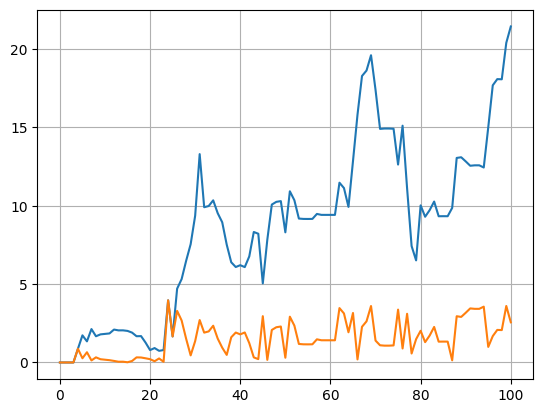

In [34]:
plt.grid(True)
plt.plot(diff_normal_mul)
plt.plot(diff_fma)